## This notebook contains exploratory data analysis of data used for training.  

In [46]:
import os
import random
import zipfile

import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from torchvision import transforms
from torchvision.transforms import Resize, Compose
from PIL import Image

from tensorflow import keras
from tensorflow.keras import Model, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, GlobalAveragePooling2D, Flatten, Dropout, BatchNormalization, Activation
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, classification_report
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import OneHotEncoder

## Computer Vision Animals-10 dataset

##### For the Computer Vision part of the task I have chosen the `Animals-10` dataset by `alessiocorrado99` from Kaggle. 
 
One can download it from `Kaggle` or use a local version.

In [6]:
import kagglehub

path = kagglehub.dataset_download("alessiocorrado99/animals10")

In [2]:
# root = os.path.join(path, 'raw-img') # kaggle
root = '../task2/data/animals10/raw-img' # locally

##### Load animal images into a dataframe.
For simplicity I am only using first 100 images for each class, as it is enough for exploratory analysis. 
The full dataset is imbalanced, so I used first 1400 images when training. Another approach would be to load everything and use an Under Sampler. I would not use an Over Sampler here. 

In [25]:
image_paths = []
labels = []

# for each animal (separate folder for each)
for animal in os.listdir(root):
    # join the animal folder to path
    path = os.path.join(root, animal)
    # use first 100 images to make sure the dataset is balanced
    for img in os.listdir(path)[:100]:
        # add image path
        image_paths.append(os.path.join(path, img))
        # add label (animal name)
        labels.append(animal)

In [26]:
df = pd.DataFrame({
    'image_paths' : image_paths,
    'labels' : labels
})
df.head(10)

,image_paths,labels
0,../task2/data/animals10/raw-img\cane\OIF-e2bex...,cane
1,../task2/data/animals10/raw-img\cane\OIP---A27...,cane
2,../task2/data/animals10/raw-img\cane\OIP---cBy...,cane
3,../task2/data/animals10/raw-img\cane\OIP---ZId...,cane
4,../task2/data/animals10/raw-img\cane\OIP---ZRs...,cane
5,../task2/data/animals10/raw-img\cane\OIP---_cJ...,cane
6,../task2/data/animals10/raw-img\cane\OIP--0C2k...,cane
7,../task2/data/animals10/raw-img\cane\OIP--0CZn...,cane
8,../task2/data/animals10/raw-img\cane\OIP--1QXr...,cane
9,../task2/data/animals10/raw-img\cane\OIP--2uTt...,cane


##### Translate the labels
Since the original dataset is in Italian, here is a way to translate the labels to English, as well as convert index to label and back.

In [27]:
label = {"cane": "dog",
         "cavallo": "horse",
         "elefante": "elephant",
         "farfalla": "butterfly",
         "gallina": "chicken",
         "gatto": "cat",
         "mucca": "cow",
         "pecora": "sheep",
         "ragno" : "spider",
         "scoiattolo": "squirrel"}

label_to_index = {key: idx for idx, key in enumerate(label.keys())}
index_to_label = {idx: value for key, value in label.items() for idx, k in enumerate(label.keys()) if k == key}

In [28]:
df['labels_num'] = df['labels'].map(label_to_index)
df['labels'] = df['labels'].map(label)
df.head(10)

,image_paths,labels,labels_num
0,../task2/data/animals10/raw-img\cane\OIF-e2bex...,dog,0
1,../task2/data/animals10/raw-img\cane\OIP---A27...,dog,0
2,../task2/data/animals10/raw-img\cane\OIP---cBy...,dog,0
3,../task2/data/animals10/raw-img\cane\OIP---ZId...,dog,0
4,../task2/data/animals10/raw-img\cane\OIP---ZRs...,dog,0
5,../task2/data/animals10/raw-img\cane\OIP---_cJ...,dog,0
6,../task2/data/animals10/raw-img\cane\OIP--0C2k...,dog,0
7,../task2/data/animals10/raw-img\cane\OIP--0CZn...,dog,0
8,../task2/data/animals10/raw-img\cane\OIP--1QXr...,dog,0
9,../task2/data/animals10/raw-img\cane\OIP--2uTt...,dog,0


##### I make sure the data is balanced

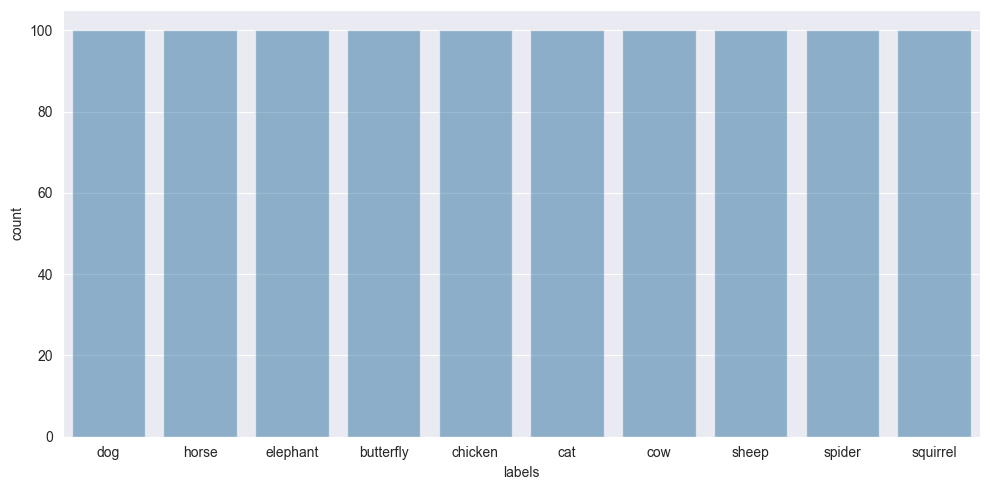

In [29]:
plt.figure(figsize=(10,5))
sns.countplot(df, x='labels', alpha = 0.5)
plt.tight_layout()

In [30]:
df.value_counts('labels')

labels
butterfly    100
cat          100
chicken      100
cow          100
dog          100
elephant     100
horse        100
sheep        100
spider       100
squirrel     100
Name: count, dtype: int64

##### Let's take a look at a few random pictures.

In [81]:
random_pictures = random.sample(range(len(df)), 12)

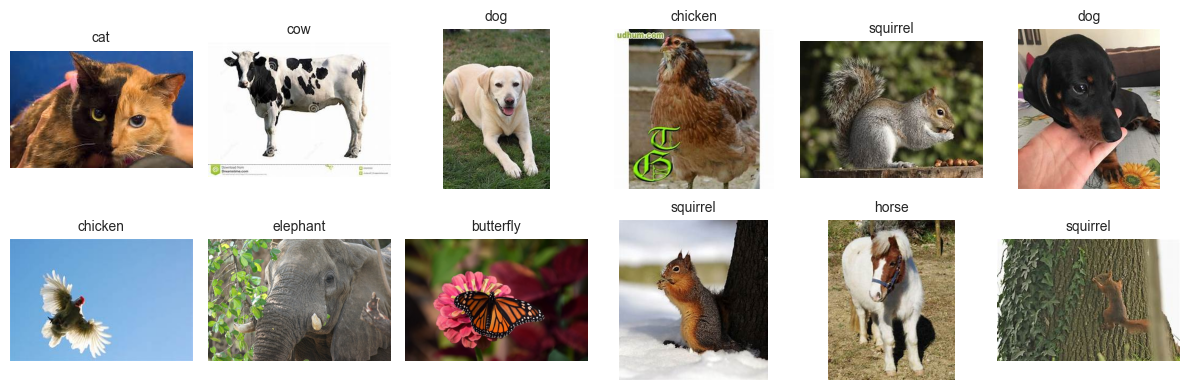

In [83]:
fig, ax = plt.subplots(2, 6, figsize=(12, 4))
ax = ax.flatten()

for i, idx in enumerate(random_pictures):
    image = plt.imread(df['image_paths'].iloc[idx])
    ax[i].imshow(image)
    ax[i].set_title(df['labels'].iloc[idx], fontsize = 10)
    ax[i].axis('off')

plt.tight_layout()
plt.show()

##### As we may see, there are many different pictures all in different sizes. Let's preprocess them.

In [69]:
all_images = []

def process_image(image_path, size=(224, 224)):
    # read an image
    image = cv2.imread(image_path)
    # cv2 reads image in BGR so convert it to RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # resize to make sure dimensions are the same for all the pictures
    image = cv2.resize(image, size)
    return image

for i in df['image_paths'].values:
    image = process_image(i)
    all_images.append(image)

##### All images are square now

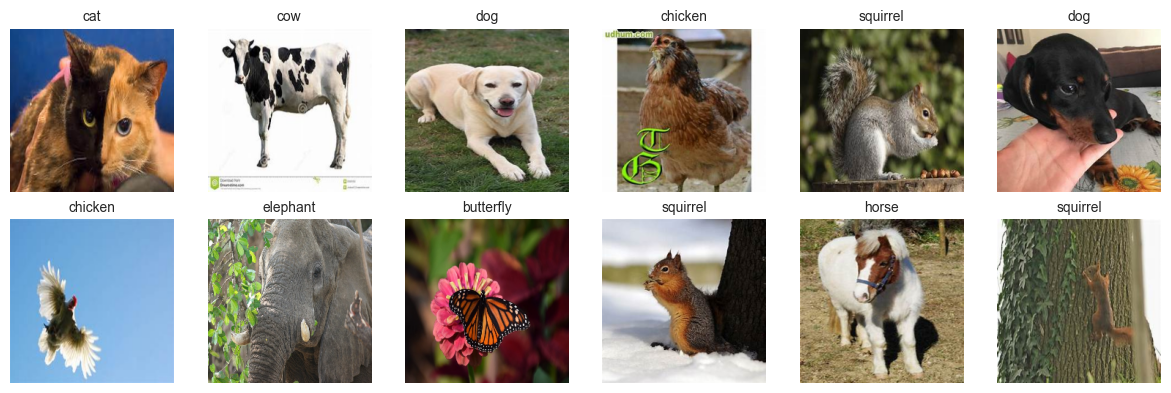

In [85]:
fig, ax = plt.subplots(2, 6, figsize=(12, 4))
ax = ax.flatten()  # Flatten for easy iteration

for i, idx in enumerate(random_pictures):
    image = all_images[idx]
    ax[i].imshow(image)  # Show image
    ax[i].set_title(df['labels'].iloc[idx], fontsize=10)  # Set label as title
    ax[i].axis('off')  # Hide axis

plt.tight_layout()
plt.show()

In [40]:
all_images = np.array(all_images)

##### Split the data 80 / 10 / 10 | train / validation / test 

In [45]:
# all data split to 80% train, 20% temp 
X_train, X_temp, y_train, y_temp = train_test_split(
    all_images, df['labels_num'],
    test_size=0.2,
    random_state=42,
    stratify=df['labels_num']
)

# temp split to 50% validation, 50% test 
X_valid, X_test, y_valid, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.5,
    random_state=42,
    stratify=y_temp
)

print(X_train.shape,y_train.shape)
print(X_valid.shape, y_valid.shape)
print(X_test.shape, y_test.shape)

(800, 224, 224, 3) (800,)
(100, 224, 224, 3) (100,)
(100, 224, 224, 3) (100,)
